# Experimental data analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import signal, interpolate, optimize
from statsmodels.tsa.statespace.varmax import VARMAX
import winsound

import os
import time
import sys
import datetime
from collections import namedtuple
import pathlib

src_path = pathlib.Path.joinpath(pathlib.Path(os.getcwd()).parent, "src")
sys.path.append(str(src_path))
from thermal_model import models

DATA_DIR = os.path.join("240209_temptest_C6B2")
TEMP_IMG_DIR = os.path.join("img_raw")
IMG_DIR = os.path.join("img_raw")
SAVE_FMT = "pdf"
SAVEFIG_PARAMS = {"dpi": 1000, "bbox_inches": "tight"}

plt.style.use("tableau-colorblind10")
# plt.rc("text", usetex=True)
# plt.rc("font", family="serif")

INTERNAL_RESISTANCE = 4


def alert():
    winsound.Beep(1440, 100)
    winsound.Beep(1440, 100)
    winsound.Beep(1440, 100)
    winsound.Beep(1440, 100)
    winsound.Beep(1440, 1000)
    winsound.Beep(1440, 100)
    winsound.Beep(1440, 100)
    winsound.Beep(1440, 100)
    winsound.Beep(1440, 100)

## Data reading

In [2]:
DATA_CHAMBER_FILENAME = os.path.join(DATA_DIR, "chamber.csv")
DATA_SENSOR_FILENAME = os.path.join(DATA_DIR, "sensor_temp.csv")
DATA_CAPACITY_FILENAME = os.path.join(DATA_DIR, "TestData.csv")
DATA_PROCEDURE_FILENAME = os.path.join(DATA_DIR, "TestProcedure.csv")

chamber_df = pd.read_csv(DATA_CHAMBER_FILENAME).drop(["Unnamed: 8"], axis=1, inplace=False)
sensor_df = pd.read_csv(
    DATA_SENSOR_FILENAME,
    header=0,
    skiprows=[1, 2, 3],
)
cap_df = pd.read_csv(
    DATA_CAPACITY_FILENAME,
    header=0,
    names=["Current", "Voltage", "Capacity", "Cumulative_capacity", "Seconds", "Test_State", "SOC"],
)
# proc_df = pd.read_csv(DATA_PROCEDURE_FILENAME)

display(chamber_df.iloc[:-4069])
display(sensor_df.iloc[:-29789])
# display(eis_df)
display(cap_df)
# display(proc_df)


# Temperature sensor data
TEMP_TIME_FULL = (sensor_df["unix_time_utc"] - sensor_df["unix_time_utc"][0]).to_numpy()
TEMP_S1_FULL = sensor_df["temp_s1"].to_numpy()
TEMP_S2_FULL = sensor_df["temp_s2"].to_numpy()
TEMP_A1_FULL = sensor_df["temp_a1"].to_numpy()
TEMP_A2_FULL = sensor_df["temp_a2"].to_numpy()
TEMP_SUR_FULL = 0.5 * (TEMP_S1_FULL + TEMP_S2_FULL)
TEMP_AIR_FULL = 0.5 * (TEMP_A1_FULL + TEMP_A2_FULL)

_TEMP_CUTOFF = -29789
TEMP_TIME = TEMP_TIME_FULL[:_TEMP_CUTOFF]
TEMP_S1 = TEMP_S1_FULL[:_TEMP_CUTOFF]
TEMP_S2 = TEMP_S2_FULL[:_TEMP_CUTOFF]
TEMP_A1 = TEMP_A1_FULL[:_TEMP_CUTOFF]
TEMP_A2 = TEMP_A2_FULL[:_TEMP_CUTOFF]
TEMP_SUR = TEMP_SUR_FULL[:_TEMP_CUTOFF]
TEMP_AIR = TEMP_AIR_FULL[:_TEMP_CUTOFF]


# Chamber data
_chamber_seconds = np.array([datetime.datetime.strptime(d, "%m/%d/%Y %H:%M:%S") for d in chamber_df["DateTime"]])
_chamber_seconds = _chamber_seconds - _chamber_seconds[0]
CHAMBER_TIME_FULL = np.array([delta.total_seconds() for delta in _chamber_seconds])
CHAMBER_SP_FULL = chamber_df["TEMPERATURE SP"].to_numpy()
CHAMBER_PV_FULL = chamber_df["TEMPERATURE PV"].to_numpy()
_CHAMBER_CUTOFF = -4069
CHAMBER_TIME = CHAMBER_TIME_FULL[:_CHAMBER_CUTOFF]
CHAMBER_SP = CHAMBER_SP_FULL[:_CHAMBER_CUTOFF]
CHAMBER_PV = CHAMBER_PV_FULL[:_CHAMBER_CUTOFF]


# Capacity data
_cap_seconds = np.array([datetime.datetime.strptime(d[:-3], "%m/%d/%Y %H:%M:%S.%f") for d in cap_df["Seconds"]])
_cap_seconds = _cap_seconds - _cap_seconds[0]
CAP_TIME = np.array([delta.total_seconds() for delta in _cap_seconds])
CAP_CURRENT = cap_df["Current"].to_numpy()
CAP_VOLTAGE = cap_df["Voltage"].to_numpy()
CAP_POWER = CAP_CURRENT * CAP_VOLTAGE
CAP_SOC = cap_df["SOC"].to_numpy()

,DateTime,CSZ System,TEMPERATURE PV,TEMPERATURE SP,TEMPERATURE %Out,PRODUCT PV,PRODUCT SP,PRODUCT %Out
0,2/8/2024 14:54:59,NaN,22.8,23.0,-3.43,23.3,23.0,0.0
1,2/8/2024 14:55:05,NaN,22.8,23.0,4.43,23.4,23.0,0.0
2,2/8/2024 14:55:11,NaN,22.8,23.0,5.83,23.4,23.0,0.0
3,2/8/2024 14:55:17,NaN,22.8,23.0,4.34,23.4,23.0,0.0
4,2/8/2024 14:55:23,NaN,22.8,23.0,1.71,23.5,23.0,0.0
...,...,...,...,...,...,...,...,...
29394,2/12/2024 07:02:00,NaN,39.7,40.0,7.03,39.7,40.0,0.0
29395,2/12/2024 07:02:06,NaN,39.8,40.0,7.64,39.7,40.0,0.0
29396,2/12/2024 07:02:12,NaN,39.8,40.0,7.92,39.6,40.0,0.0
29397,2/12/2024 07:02:18,NaN,39.8,40.0,2.90,39.6,40.0,0.0


,timestamp_utc,unix_time_utc,cell,res_s1,temp_s1,res_s2,temp_s2,res_a1,temp_a1,res_a2,temp_a2
0,2024-02-08 17:56:29.383718+00:00,1707414989,0,104191.62,24,104191.62,24,101775.15,25,110061.60,23
1,2024-02-08 17:56:29.385718+00:00,1707414989,0,106666.67,24,104191.62,24,107085.03,23,105835.02,24
2,2024-02-08 17:56:30.338665+00:00,1707414990,0,110927.84,23,104191.62,24,103784.87,24,107085.03,23
3,2024-02-08 17:56:31.382698+00:00,1707414991,0,106666.67,24,104191.62,24,103784.87,24,99027.25,25
4,2024-02-08 17:56:32.426367+00:00,1707414992,0,109202.46,23,103784.87,24,97109.84,26,105835.02,24
...,...,...,...,...,...,...,...,...,...,...,...
303508,2024-02-12 10:02:21.163713+00:00,1707732141,0,53373.31,40,52459.01,40,52005.94,41,48691.86,42
303509,2024-02-12 10:02:22.209172+00:00,1707732142,0,53834.59,40,52459.01,40,52232.14,41,54531.72,39
303510,2024-02-12 10:02:23.253479+00:00,1707732143,0,52459.01,40,52232.14,41,52686.57,40,56661.56,38
303511,2024-02-12 10:02:24.297272+00:00,1707732144,0,46561.60,43,51331.36,41,50662.74,41,53603.60,40


,Current,Voltage,Capacity,Cumulative_capacity,Seconds,Test_State,SOC
0,-0.000100,4.15683,0.000000,0.000000,02/08/2024 14:56:39.011613500,2,0.000000
1,-0.000100,4.15680,-0.000030,-0.000030,02/08/2024 14:56:40.095181620,2,-0.000001
2,-0.000100,4.15680,-0.000030,-0.000060,02/08/2024 14:56:41.178775180,2,-0.000003
3,-2.247890,3.71654,0.000000,0.000000,02/08/2024 14:56:55.433992780,1,100.000000
4,-2.247900,3.70629,-0.676585,-0.676585,02/08/2024 14:56:56.517541340,1,99.966700
...,...,...,...,...,...,...,...
163463,0.110377,4.20000,0.033220,2114.600000,02/12/2024 07:02:20.973081140,3,104.014000
163464,0.110321,4.20000,0.033203,2114.630000,02/12/2024 07:02:22.056571680,3,104.015000
163465,0.110251,4.20000,0.033183,2114.660000,02/12/2024 07:02:23.140079340,3,104.017000
163466,0.110183,4.20000,0.033162,2114.700000,02/12/2024 07:02:24.223572900,3,104.018000


## Data preprocessing
The preprocessing steps are
- Segmentation based on working intervals of the capacity testing equipment
- Resampling and low-pass filtering for temperature sensor data
- Interpolation and extrapolation for temperature chamber data

After preprocessing, all relevant arrays have the same number of elements, corresponding to the same time instants.

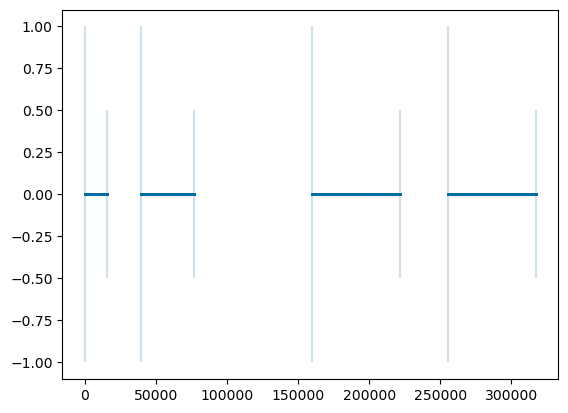

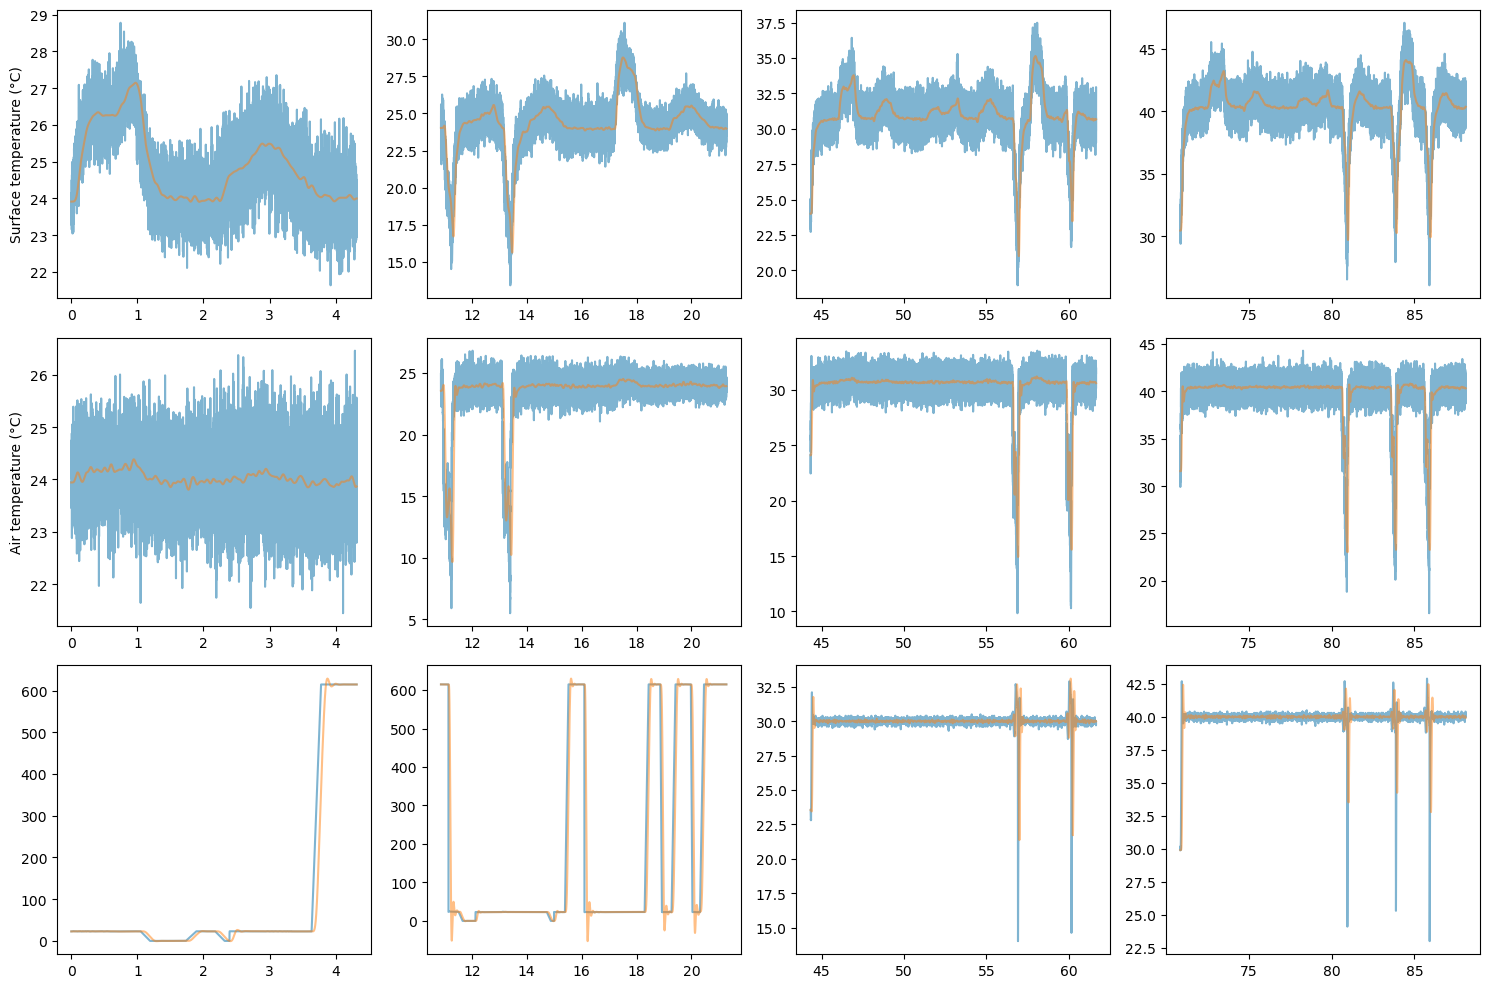

In [3]:
_TIME_LIMIT = 50
starts_idx = np.concatenate(([0], np.where((CAP_TIME[1:] - CAP_TIME[:-1]) >= _TIME_LIMIT)[0] + 1))
ends_idx = np.concatenate((np.where((CAP_TIME[1:] - CAP_TIME[:-1]) >= _TIME_LIMIT)[0], [-1]))
starts = CAP_TIME[starts_idx]
ends = CAP_TIME[ends_idx]


fig, ax = plt.subplots()
ax.scatter(CAP_TIME, np.zeros(CAP_TIME.shape), s=1)
ax.vlines(starts, -1, 1, alpha=0.2)
ax.vlines(ends, -0.5, 0.5, alpha=0.2)


segments_total = sum(1 for _ in zip(starts, ends))
temp_masks = [(s <= TEMP_TIME) & (TEMP_TIME <= e) for s, e in zip(starts, ends)]
chamber_masks = [(s <= CHAMBER_TIME) & (CHAMBER_TIME <= e) for s, e in zip(starts, ends)]
cap_masks = [(s <= CAP_TIME) & (CAP_TIME <= e) for s, e in zip(starts, ends)]

# All segments will always have `segments_total` elements
# The variables `temp_*_rs_segs` correspond to segmented and resampled temperature sensor data,
# while `temp_*_segs` also is low-pass filtred to remove sensor noise

cap_time_segs = [CAP_TIME[m] for m in cap_masks]
cap_current_segs = [CAP_CURRENT[m] for m in cap_masks]
cap_voltage_segs = [CAP_VOLTAGE[m] for m in cap_masks]
cap_power_segs = [CAP_POWER[m] for m in cap_masks]
cap_soc_segs = [CAP_SOC[m] for m in cap_masks]

temp_time_segs = [TEMP_TIME[m] for m in temp_masks]
temp_sur_raw_segs = [TEMP_SUR[m] for m in temp_masks]
temp_air_raw_segs = [TEMP_AIR[m] for m in temp_masks]
temp_sur_rs_segs = [signal.resample(temp_sur_raw_segs[i], len(cap_time_segs[i])) for i in range(segments_total)]
temp_air_rs_segs = [signal.resample(temp_air_raw_segs[i], len(cap_time_segs[i])) for i in range(segments_total)]
b, a = signal.butter(5, 0.005)
_zi = signal.lfilter_zi(b, a)
temp_sur_segs = [signal.lfilter(b, a, temp, zi=_zi * temp[0])[0] for temp in temp_sur_rs_segs]
temp_air_segs = [signal.lfilter(b, a, temp, zi=_zi * temp[0])[0] for temp in temp_air_rs_segs]
gen_heat_segs = [models.generated_heat_from_current(current, temp, soc, INTERNAL_RESISTANCE) for current, temp, soc in zip(cap_current_segs, temp_sur_segs, cap_soc_segs)]

chamber_time_segs = [CHAMBER_TIME[m] for m in chamber_masks]
chamber_sp_raw_segs = [CHAMBER_SP[m] for m in chamber_masks]
chamber_pv_raw_segs = [CHAMBER_PV[m] for m in chamber_masks]
_sp_lerp = [interpolate.interp1d(t, y, fill_value="extrapolate") for t, y in zip(chamber_time_segs, chamber_sp_raw_segs)]
_pv_lerp = [interpolate.interp1d(t, y, fill_value="extrapolate") for t, y in zip(chamber_time_segs, chamber_pv_raw_segs)]
chamber_sp_segs = [f(t) for t, f in zip(cap_time_segs, _sp_lerp)]
chamber_pv_rs_segs = [f(t) for t, f in zip(cap_time_segs, _pv_lerp)]
chamber_pv_segs = [signal.lfilter(b, a, temp, zi=_zi * temp[0])[0] for temp in chamber_pv_rs_segs]


temp_sensor_std = temp_air_segs[2][1000:30000].std()
chamber_pv_std = chamber_pv_segs[2][1000:30000].std()


fig, axs = plt.subplots(3, segments_total, figsize=(15, 10))
for i, ax in enumerate(axs[0]):
    ax.plot(cap_time_segs[i] / 3600, temp_sur_rs_segs[i], label="$T^{{MMSEE}}_{{sur}}$, resampled", alpha=0.5)
    ax.plot(cap_time_segs[i] / 3600, temp_sur_segs[i], label="$T^{{MMSEE}}_{{sur}}$, resampled and filtered", alpha=0.5)
for i, ax in enumerate(axs[1]):
    ax.plot(cap_time_segs[i] / 3600, temp_air_rs_segs[i], label="$T^{{MMSEE}}_{{air}}$, resampled", alpha=0.5)
    ax.plot(cap_time_segs[i] / 3600, temp_air_segs[i], label="$T^{{MMSEE}}_{{air}}$, resampled and filtered", alpha=0.5)
for i, ax in enumerate(axs[2]):
    ax.plot(cap_time_segs[i] / 3600, chamber_pv_rs_segs[i], label="$T^{{MMSEE}}_{{pv}}$, resampled", alpha=0.5)
    ax.plot(cap_time_segs[i] / 3600, chamber_pv_segs[i], label="$T^{{MMSEE}}_{{pv}}$, resampled and filtered", alpha=0.5)
axs[0][0].set_ylabel("Surface temperature (°C)")
axs[1][0].set_ylabel("Air temperature (°C)")


fig.tight_layout()
plt.show()

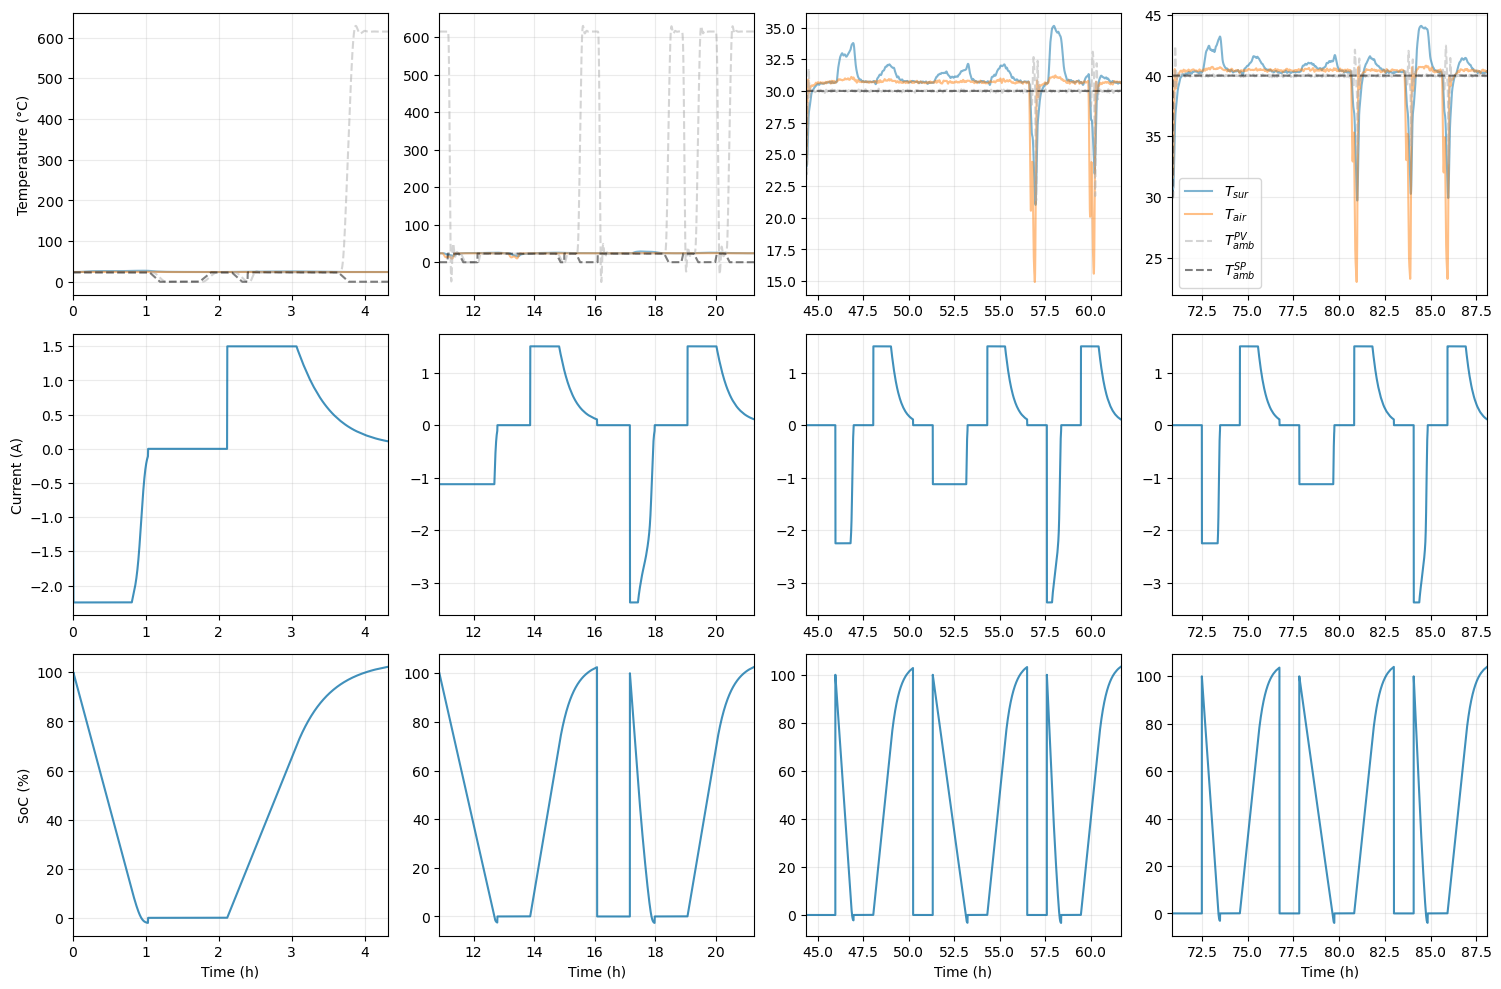

In [4]:
fig, axs = plt.subplots(3, segments_total, figsize=(15, 10))

for i, ax in enumerate(axs[0]):
    ax.plot(cap_time_segs[i] / 3600, temp_sur_segs[i], label="$T_{{sur}}$", alpha=0.5)
    ax.plot(cap_time_segs[i] / 3600, temp_air_segs[i], label="$T_{{air}}$", alpha=0.5)
    ax.plot(cap_time_segs[i] / 3600, chamber_pv_segs[i], label="$T_{{amb}}^{{PV}}$", alpha=0.5, linestyle="--")
    ax.plot(cap_time_segs[i] / 3600, chamber_sp_segs[i], label="$T_{{amb}}^{{SP}}$", alpha=0.5, linestyle="--", color="k")

    ax.set_xlim(*(cap_time_segs[i][[0, -1]] / 3600))
    ax.grid(alpha=0.25)

for i, ax in enumerate(axs[1]):
    ax.plot(cap_time_segs[i] / 3600, cap_current_segs[i], label="$I$ (A)", alpha=0.75)

    ax.set_xlim(*(cap_time_segs[i][[0, -1]] / 3600))
    ax.grid(alpha=0.25)

for i, ax in enumerate(axs[2]):
    ax.plot(cap_time_segs[i] / 3600, cap_soc_segs[i], label="SoC (%)", alpha=0.75)

    ax.set_xlim(*(cap_time_segs[i][[0, -1]] / 3600))
    ax.grid(alpha=0.25)

axs[0][0].set_ylabel("Temperature (°C)")
axs[1][0].set_ylabel("Current (A)")
axs[2][0].set_ylabel("SoC (%)")
for ax in axs[2]:
    ax.set_xlabel("Time (h)")
axs[0][-1].legend()

fig.tight_layout()

## Parameter identification
Considering the following variables
$$
\mathbf{x} \triangleq \left(\begin{matrix}
T_{\mathrm{in}} \\
T_{\mathrm{air}} \\
\end{matrix}\right), \mathbf{y} \triangleq \left(\begin{matrix}
T_{\mathrm{s}} \\
T_{\mathrm{air}} \\
\end{matrix}\right), \mathbf{u} \triangleq \left(\begin{matrix}
T_{\mathrm{amb}} \\
q_{\mathrm{gen}} \\
\end{matrix}\right),
$$
then the underlying thermal model for a single cell can be expressed as the following MIMO LTI system
$$
\dot{\mathbf{x}} = \left(\begin{matrix}
-\frac{1}{C_p R_T} & \frac{1}{C_p R_T} \\
\frac{1}{C_{\mathrm{air}} R_T} & -\frac{R_{\mathrm{air}} + R_T}{C_{\mathrm{air}} R_{\mathrm{air}} R_T} \\
\end{matrix}\right)\mathbf{x} + \left(\begin{matrix}
0 & \frac{1}{C_p} \\
\frac{1}{C_{\mathrm{air}} R_{\mathrm{air}}} & 0 \\
\end{matrix}\right)\mathbf{u} \\
\mathbf{y} = \left(\begin{matrix}
\frac{R_{\mathrm{out}}}{R_T} & \frac{R_{\mathrm{in}}}{R_T} \\
0 & 1 \\
\end{matrix}\right)\mathbf{x},
$$
where $R_{T} \triangleq R_{\mathrm{in}} + R_{\mathrm{out}}$. Then, an LTI system is identified from the data, from which the thermal parameters are obtained.

### VARMAX

In [7]:
_TRAINING_SEGMENT = -1

endog = np.array([temp_sur_segs[_TRAINING_SEGMENT], temp_air_segs[_TRAINING_SEGMENT]]).T
exog = np.array([chamber_sp_segs[_TRAINING_SEGMENT], gen_heat_segs[_TRAINING_SEGMENT]]).T

model = VARMAX(endog, exog, (2, 2), measurement_error=True)

c:\Users\Cristobal\.conda\envs\case\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [8]:
res = model.fit(maxiter=1000)
print(res.summary())

KeyboardInterrupt: 

In [ ]:
_IDX = 249
a = res.simulate(_IDX, exog=np.array([chamber_sp_segs[2], gen_heat_segs[2]]).T[:_IDX, :], initial_state=30 * np.ones(8))


c:\Users\Cristobal\.conda\envs\case\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1784: ValueWarning: Exogenous array provided, but additional data is not required. `exog` argument ignored.
  warnings.warn('Exogenous array provided, but additional data'


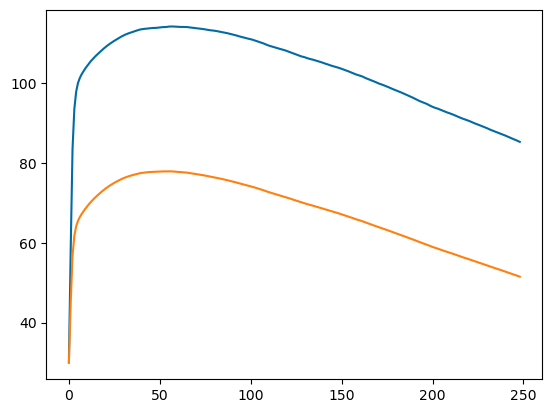

In [ ]:
plt.plot(a)

### DMDc

In [30]:
_TRAINING_SEGMENT = -1

_CUTOFF = 32000
t_train = np.linspace(0, cap_time_segs[_TRAINING_SEGMENT][-1] - cap_time_segs[_TRAINING_SEGMENT][0], len(cap_time_segs[_TRAINING_SEGMENT]))[:_CUTOFF]
dt_train = t_train[1] - t_train[0]
y_train = np.array([temp_sur_segs[_TRAINING_SEGMENT], temp_air_segs[_TRAINING_SEGMENT]])[:_CUTOFF, :]
u_train = np.array([chamber_pv_segs[_TRAINING_SEGMENT], gen_heat_segs[_TRAINING_SEGMENT]])[:_CUTOFF, :]

states = y_train[:, :-1]
states_shifted = y_train[:, 1:]
inputs = u_train[:, :-1]


result = (states_shifted @ np.linalg.pinv(np.vstack((states, inputs))))
Ad = result[:, :2]
Bd = result[:, 2:]

print(f"Ad = \n{Ad}")
print(f"Bd = \n{Bd}")

A = (Ad - np.eye(2)) / dt_train
B = Bd / dt_train
sys_train = signal.lti(A, B, np.eye(2), np.zeros((2, 2)))

print(f"A = \n{A}")
print(f"B = \n{B}")

poles_d = np.linalg.eig(Ad)[0]
poles = np.linalg.eig(A)[0]
print(f"Discrete poles: {poles_d}")
print(f"Continuous poles: {poles}")
if (np.abs(poles) >= 1).any() or (poles.real > 0).any():
    print("!!! System is unstable !!!")


def target_response_dmdc(u, t, x0, sys):
    y = sys.output(u, t, x0)[1]
    return y


def generate_evaluation_dmdc(expected, u, t, x0):
    def _generate_system(sys) -> float:
        y = target_response_dmdc(u, t, x0, sys)
        error = expected - y
        return expected, y, error
    return _generate_system

Ad = 
[[ 0.99746423  0.00221298]
 [-0.00287009  1.00220908]]
Bd = 
[[0.00033041 0.00021076]
 [0.00067062 0.00018982]]
A = 
[[-0.00233726  0.00203974]
 [-0.00264541  0.00203614]]
B = 
[[0.00030455 0.00019426]
 [0.00061812 0.00017496]]
Discrete poles: [0.99983665+0.00085033j 0.99983665-0.00085033j]
Continuous poles: [-0.00015056+0.00078376j -0.00015056-0.00078376j]


MSE: [13.72795219 20.9423618 ]


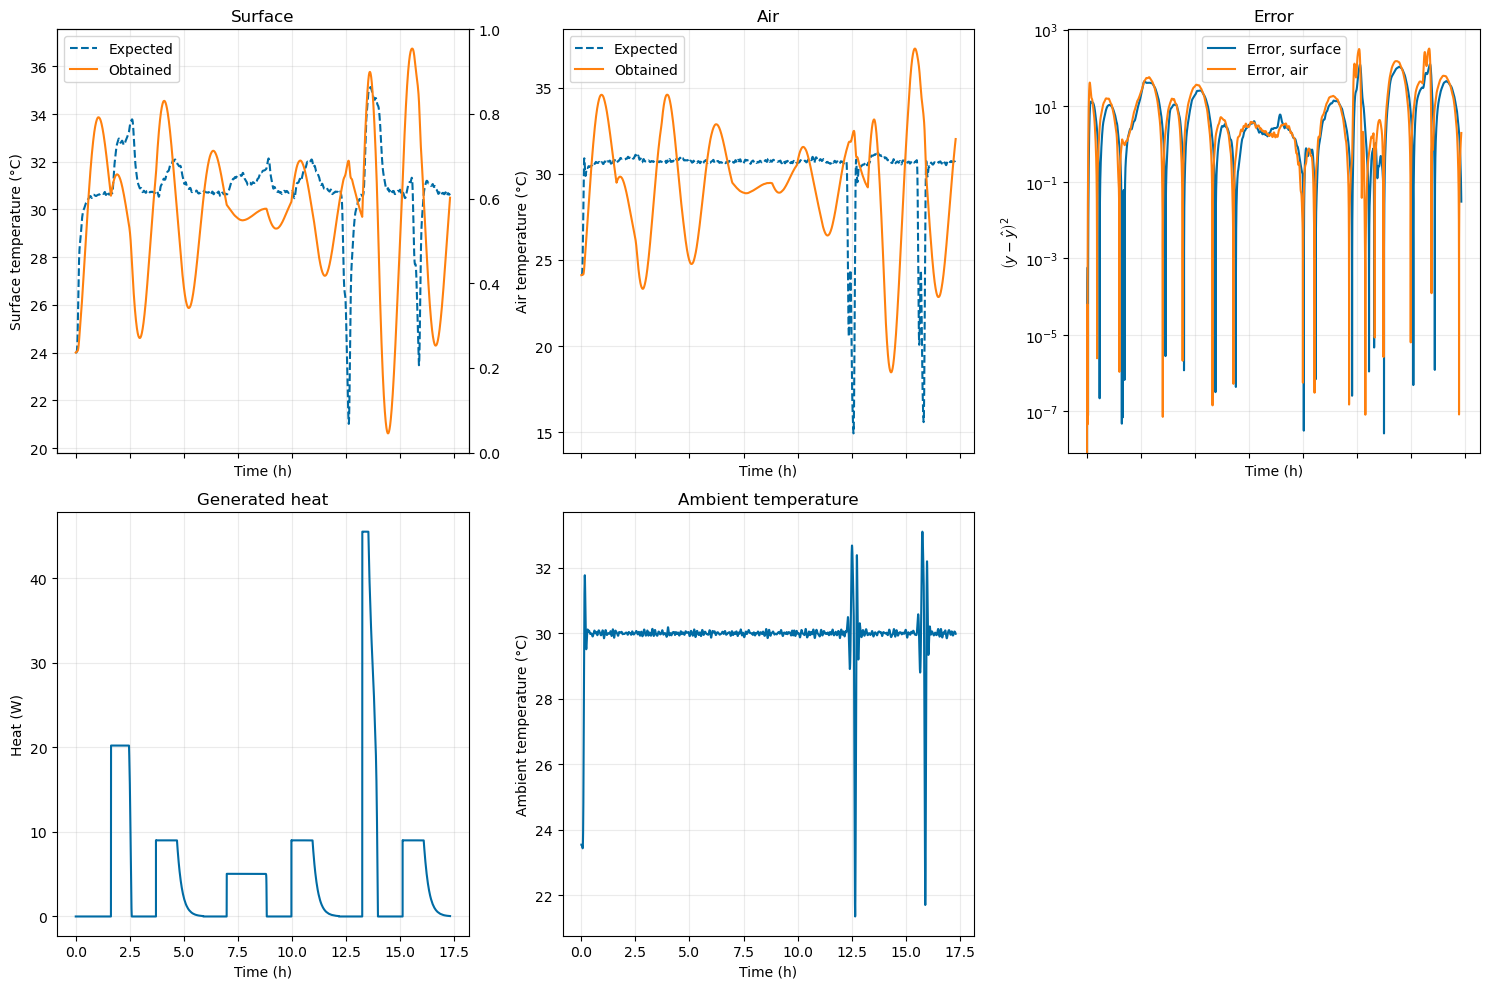

In [33]:
_EVAL_SEGMENT = 2
t_eval = np.linspace(0, cap_time_segs[_EVAL_SEGMENT][-1] - cap_time_segs[_EVAL_SEGMENT][0], len(cap_time_segs[_EVAL_SEGMENT]))
y_eval = np.array([temp_sur_segs[_EVAL_SEGMENT], temp_air_segs[_EVAL_SEGMENT]]).T
u_eval = np.array([chamber_pv_segs[_EVAL_SEGMENT], gen_heat_segs[_EVAL_SEGMENT]]).T
x0_eval = y_eval[0] # We assume the observations match the states at the beginning

evaluate = generate_evaluation_dmdc(y_eval, u_eval, t_eval, x0_eval)
expected, obtained, error = evaluate(sys_train)
error_square = error ** 2
mse = np.diag(error.conjugate().T @ error) / len(error)
print(f"MSE: {mse}")

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10), sharex=True)

ax1_2 = ax1.twinx()
ax1.plot(t_eval / 3600, expected[:, 0], label="Expected", linestyle="--")
ax1.plot(t_eval / 3600, obtained[:, 0], label="Obtained")
ax2.plot(t_eval / 3600, expected[:, 1], label="Expected", linestyle="--")
ax2.plot(t_eval / 3600, obtained[:, 1], label="Obtained")
ax3.plot(t_eval / 3600, error_square[:, 0], label="Error, surface")
ax3.plot(t_eval / 3600, error_square[:, 1], label="Error, air")

ax4.plot(t_eval / 3600, u_eval[:, 1], label="Generated heat")
ax5.plot(t_eval / 3600, u_eval[:, 0], label="Ambient temperature")
ax6.remove()

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Surface temperature (°C)")
ax2.set_xlabel("Time (h)")
ax2.set_ylabel("Air temperature (°C)")
ax3.set_xlabel("Time (h)")
ax3.set_ylabel("$\\left(y - \\hat y\\right)^2$")
ax4.set_xlabel("Time (h)")
ax4.set_ylabel("Heat (W)")
ax5.set_xlabel("Time (h)")
ax5.set_ylabel("Ambient temperature (°C)")

ax1.set_title("Surface")
ax2.set_title("Air")
ax3.set_title("Error")
ax4.set_title("Generated heat")
ax5.set_title("Ambient temperature")

ax1.legend()
ax2.legend()
ax3.legend()
ax1.grid(alpha=0.25)
ax2.grid(alpha=0.25)
ax3.grid(alpha=0.25)
ax4.grid(alpha=0.25)
ax5.grid(alpha=0.25)

ax3.set_yscale("log")

fig.tight_layout()
plt.show()

### Iterative algorithms

In [7]:
_TRAINING_SEGMENT = -1

_CUTOFF = 32000
t_train = np.linspace(0, cap_time_segs[_TRAINING_SEGMENT][-1] - cap_time_segs[_TRAINING_SEGMENT][0], len(cap_time_segs[_TRAINING_SEGMENT]))[:_CUTOFF]
y_train = np.array([temp_sur_segs[_TRAINING_SEGMENT], temp_air_segs[_TRAINING_SEGMENT]]).T[:_CUTOFF, :]
u_train = np.array([chamber_pv_segs[_TRAINING_SEGMENT], gen_heat_segs[_TRAINING_SEGMENT]]).T[:_CUTOFF, :]
x0_train = y_train[0] # We assume the observations match the states at the beginning


TargetParams = namedtuple("TargetParams", "cp cair rair rin rout")
PARAMS1 = TargetParams(cp=29.604854855435384, cair=14.403798771439101, rair=0.027775716955409813, rin=34.051506057316416, rout=0.09176371638499373)
PARAMS2 = TargetParams(cp=1751.3595602263526, cair=9976.137906869928, rair=0.031485160985154415, rin=0.45465025035185824, rout=0.0903311199737274)
PARAMS3 = TargetParams(cp=2297.2830850423516, cair=35.62346086817191, rair=0.04769018866592217, rin=0.4268412170392377, rout=0.12689196832834176)
PARAMS4 = TargetParams(cp=2288.8086878520617, cair=40.68543129463231, rair=0.05622811486407936, rin=0.29153746960754423, rout=0.09544187302807855)
BEST_PARAMS = PARAMS4


def target_lti_parameters(params: TargetParams):
    """Returns the A, B, C, D matrices of the target LTI system"""
    rt = params.rin + params.rout
    a_mat = np.array([
        [-1 / (params.cp * rt), 1 / (params.cp * rt)],
        [1 / (params.cair * rt), -(params.rair + rt) / (params.cair * params.rair * rt)],
    ])
    b_mat = np.array([
        [0, 1 / params.cp],
        [1 / (params.cair * params.rair), 0],
    ])
    c_mat = np.array([
        [params.rout / rt, params.rin / rt],
        [0, 1],
    ])
    d_mat = np.zeros((2, 2))
    return a_mat, b_mat, c_mat, d_mat


def target_lti(params: TargetParams) -> signal.StateSpace:
    """Returns an LTI StateSpace instance for the corresponding values"""
    return signal.lti(*target_lti_parameters(params))


def target_response_noisy(u, t, x0, params: TargetParams):
    sys = target_lti(params)
    model_noise = np.random.normal(0, chamber_pv_std, u.shape)
    y = sys.output(u + model_noise, t, x0)[1]
    sensor_noise = np.random.normal(0, temp_sensor_std, y.shape)
    return y + sensor_noise


def target_response(u, t, x0, params: TargetParams):
    sys = target_lti(params)
    y = sys.output(u, t, x0)[1]
    return y


def generate_mse_error(expected, u, t, x0):
    def _generate_system(params: TargetParams) -> float:
        obtained = target_response_noisy(u, t, x0, params)
        error = expected - obtained
        return np.diag(error.conjugate().T @ error).sum()
    return _generate_system


def generate_evaluation(expected, u, t, x0):
    def _generate_system(params: TargetParams) -> float:
        y = target_response(u, t, x0, params)
        error = expected - y
        return expected, y, error
    return _generate_system

In [89]:
# _INITIAL_GUESS = np.array([100, 100, 1, 1, 1])
_INITIAL_GUESS = np.array([*BEST_PARAMS])
mse_error = generate_mse_error(y_train, u_train, t_train, x0_train)

params = optimize.minimize(
    lambda p: mse_error(TargetParams(*p)),
    _INITIAL_GUESS,
    bounds=optimize.Bounds(0, np.inf),
    jac="3-point",
    hess="3-point",
    method="Nelder-Mead",
    options={
        "maxiter": 10000,
        "disp": True,
    },
)

# params = optimize.basinhopping(
#     lambda p: mse_error(TargetParams(*p)),
#     _INITIAL_GUESS,
#     minimizer_kwargs={
#         "bounds": optimize.Bounds(0, np.inf),
#         "jac": "3-point",
#         "hess": "3-point",
#         "method": "Nelder-Mead",
#         "options": {
#             "disp": True,
#         },
#     },
# )


A, B, C, _ = target_lti_parameters(TargetParams(*params.x))
display(params)
print(f"Final parameters: {TargetParams(*params.x)}")
print(f"A = \n{A}")
print(f"B = \n{B}")
print(f"C = \n{C}")

print(f"Continous poles: {np.linalg.eig(A)[0]}")

if np.linalg.matrix_rank(np.vstack([C, C @ A])) != 2:
    print("!!! SYSTEM IS NOT OBSERVABLE !!!")
alert()

C:\Users\Cristobal\AppData\Local\Temp\ipykernel_8640\2715988400.py:5: RuntimeWarning: Maximum number of iterations has been exceeded.
  params = optimize.minimize(


       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 13717.595563886716
             x: [ 2.289e+03  4.069e+01  5.623e-02  2.915e-01  9.544e-02]
           nit: 10000
          nfev: 27185
 final_simplex: (array([[ 2.289e+03,  4.069e+01, ...,  2.915e-01,
                         9.544e-02],
                       [ 2.289e+03,  4.069e+01, ...,  2.915e-01,
                         9.544e-02],
                       ...,
                       [ 2.289e+03,  4.069e+01, ...,  2.915e-01,
                         9.544e-02],
                       [ 2.289e+03,  4.069e+01, ...,  2.915e-01,
                         9.544e-02]]), array([ 1.372e+04,  1.374e+04,  1.377e+04,  1.380e+04,
                        1.381e+04,  1.384e+04]))

Final parameters: TargetParams(cp=2288.8086878520617, cair=40.68543129463231, rair=0.05622811486407936, rin=0.29153746960754423, rout=0.09544187302807855)
A = 
[[-0.00112902  0.00112902]
 [ 0.06351456 -0.50064148]]
B = 
[[0.00000000e+00 4.36908513e-04]
 [4.37126920e-01 0.00000000e+00]]
C = 
[[0.24663299 0.75336701]
 [0.         1.        ]]


MSE: [1.50804514 5.01296285]


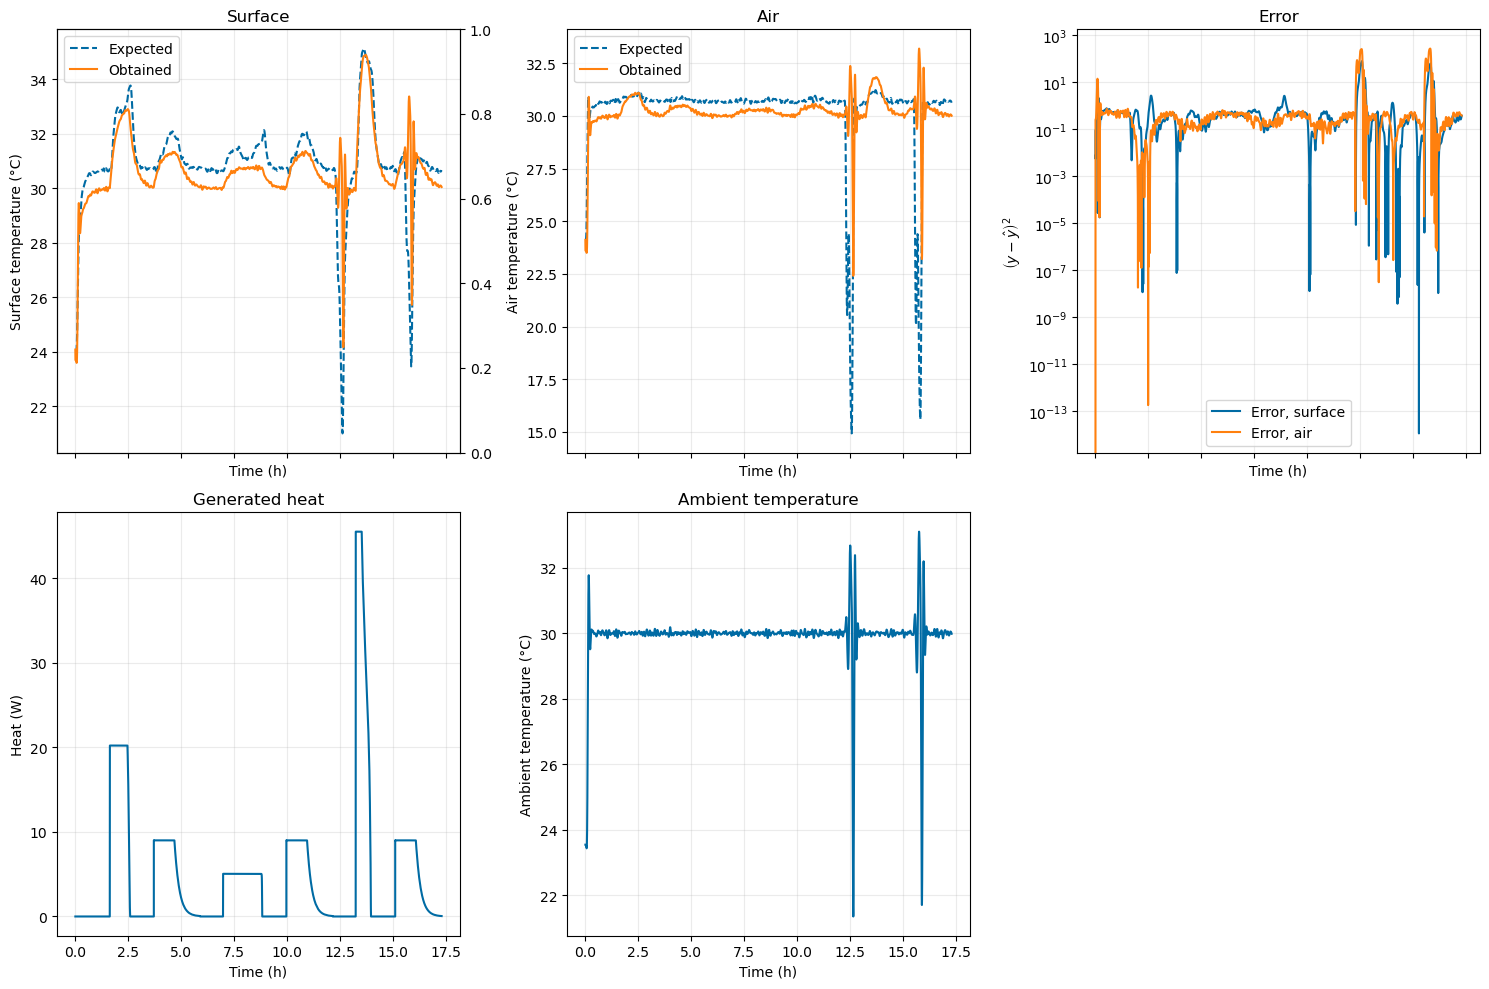

In [90]:
_EVAL_SEGMENT = 2
t_eval = np.linspace(0, cap_time_segs[_EVAL_SEGMENT][-1] - cap_time_segs[_EVAL_SEGMENT][0], len(cap_time_segs[_EVAL_SEGMENT]))
y_eval = np.array([temp_sur_segs[_EVAL_SEGMENT], temp_air_segs[_EVAL_SEGMENT]]).T
u_eval = np.array([chamber_pv_segs[_EVAL_SEGMENT], gen_heat_segs[_EVAL_SEGMENT]]).T
x0_eval = y_eval[0] # We assume the observations match the states at the beginning

evaluate = generate_evaluation(y_eval, u_eval, t_eval, x0_eval)
expected, obtained, error = evaluate(TargetParams(*params.x))
error_square = error ** 2
mse = np.diag(error.conjugate().T @ error) / len(error)
print(f"MSE: {mse}")

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10), sharex=True)

ax1_2 = ax1.twinx()
ax1.plot(t_eval / 3600, expected[:, 0], label="Expected", linestyle="--")
ax1.plot(t_eval / 3600, obtained[:, 0], label="Obtained")
ax2.plot(t_eval / 3600, expected[:, 1], label="Expected", linestyle="--")
ax2.plot(t_eval / 3600, obtained[:, 1], label="Obtained")
ax3.plot(t_eval / 3600, error_square[:, 0], label="Error, surface")
ax3.plot(t_eval / 3600, error_square[:, 1], label="Error, air")

ax4.plot(t_eval / 3600, u_eval[:, 1], label="Generated heat")
ax5.plot(t_eval / 3600, u_eval[:, 0], label="Ambient temperature")
ax6.remove()

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Surface temperature (°C)")
ax2.set_xlabel("Time (h)")
ax2.set_ylabel("Air temperature (°C)")
ax3.set_xlabel("Time (h)")
ax3.set_ylabel("$\\left(y - \\hat y\\right)^2$")
ax4.set_xlabel("Time (h)")
ax4.set_ylabel("Heat (W)")
ax5.set_xlabel("Time (h)")
ax5.set_ylabel("Ambient temperature (°C)")

ax1.set_title("Surface")
ax2.set_title("Air")
ax3.set_title("Error")
ax4.set_title("Generated heat")
ax5.set_title("Ambient temperature")

ax1.legend()
ax2.legend()
ax3.legend()
ax1.grid(alpha=0.25)
ax2.grid(alpha=0.25)
ax3.grid(alpha=0.25)
ax4.grid(alpha=0.25)
ax5.grid(alpha=0.25)

ax3.set_yscale("log")

fig.tight_layout()
plt.show()

MSE1: [1.50804514 5.01296285]
MSE2: [1.47825465 5.01324718]


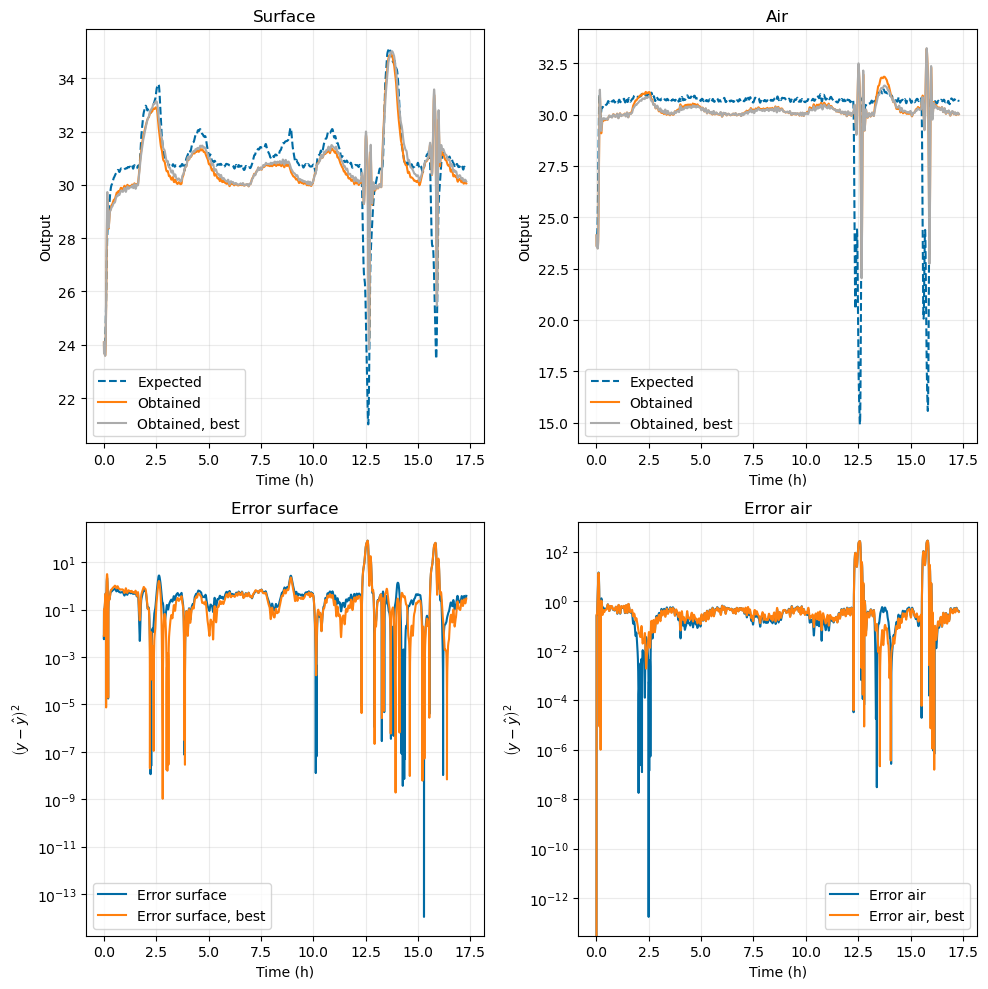

In [91]:
_EVAL_SEGMENT = 2
t_eval = np.linspace(0, cap_time_segs[_EVAL_SEGMENT][-1] - cap_time_segs[_EVAL_SEGMENT][0], len(cap_time_segs[_EVAL_SEGMENT]))
y_eval = np.array([temp_sur_segs[_EVAL_SEGMENT], temp_air_segs[_EVAL_SEGMENT]]).T
u_eval = np.array([chamber_pv_segs[_EVAL_SEGMENT], gen_heat_segs[_EVAL_SEGMENT]]).T
x0_eval = y_eval[0] # We assume the observations match the states at the beginning

evaluate = generate_evaluation(y_eval, u_eval, t_eval, x0_eval)
expected1, obtained1, error1 = evaluate(TargetParams(*params.x))
error1_square = error1 ** 2
mse1 = np.diag(error1.conjugate().T @ error1) / len(error1)
print(f"MSE1: {mse1}")
expected2, obtained2, error2 = evaluate(BEST_PARAMS)
error2_square = error2 ** 2
mse2 = np.diag(error2.conjugate().T @ error2) / len(error2)
print(f"MSE2: {mse2}")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

ax1.plot(t_eval / 3600, expected1[:, 0], label="Expected", linestyle="--")
ax1.plot(t_eval / 3600, obtained1[:, 0], label="Obtained")
ax1.plot(t_eval / 3600, obtained2[:, 0], label="Obtained, best")
ax2.plot(t_eval / 3600, expected1[:, 1], label="Expected", linestyle="--")
ax2.plot(t_eval / 3600, obtained1[:, 1], label="Obtained")
ax2.plot(t_eval / 3600, obtained2[:, 1], label="Obtained, best")
ax3.plot(t_eval / 3600, error1_square[:, 0], label="Error surface")
ax3.plot(t_eval / 3600, error2_square[:, 0], label="Error surface, best")
ax4.plot(t_eval / 3600, error1_square[:, 1], label="Error air")
ax4.plot(t_eval / 3600, error2_square[:, 1], label="Error air, best")

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Output")
ax2.set_xlabel("Time (h)")
ax2.set_ylabel("Output")
ax3.set_xlabel("Time (h)")
ax3.set_ylabel("$\\left(y - \\hat y\\right)^2$")
ax4.set_xlabel("Time (h)")
ax4.set_ylabel("$\\left(y - \\hat y\\right)^2$")

ax1.set_title("Surface")
ax2.set_title("Air")
ax3.set_title("Error surface")
ax4.set_title("Error air")

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax1.grid(alpha=0.25)
ax2.grid(alpha=0.25)
ax3.grid(alpha=0.25)
ax4.grid(alpha=0.25)

ax3.set_yscale("log")
ax4.set_yscale("log")

fig.tight_layout()
plt.show()